# Fase de Modelación

## Importaciones y setup:

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import shap
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import multiprocessing
seed = 42

In [ ]:
dm = pd.read_json("modellingData.json")
dm.head()

In [28]:
dm['Precio'].describe()

count    4.518000e+03
mean     6.551435e+08
std      5.483981e+08
min      1.200000e+08
25%      3.500000e+08
50%      4.900000e+08
75%      7.500000e+08
max      4.500000e+09
Name: Precio, dtype: float64

### Matriz de Correlación

In [ ]:
corr = dm.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, 
            annot=False,          # muestra los valores numéricos
            fmt=".2f",           # formato de decimales
            cmap="coolwarm",     # paleta de colores
            center=0,            # centra el color en 0 (rojo-negativo, azul-positivo)
            linewidths=0.5)

plt.title("Mapa de calor de correlaciones entre variables numéricas")
plt.show()

La matriz de correlación de pearson nos muestra el impacto de una variable en otra. Por ejemplo, podemos ver que la latitud cambia al ver las dummies de ciudad (viendo que Bello este en el norte y Sabaneta en el sur). Así mismo analizamos que los baños y los parqueaderos son métricas importantes en el precio. Vemos que las casas en Envigado y Medellín son más caras que en el resto de ciudades del área metropolitana.  

## Análisis de importancia

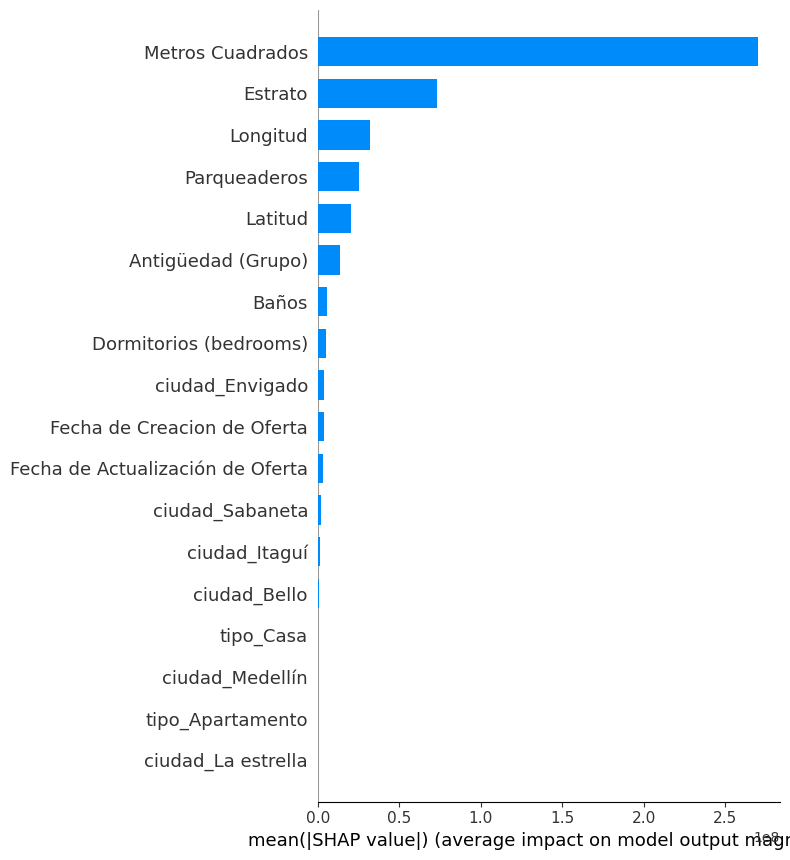

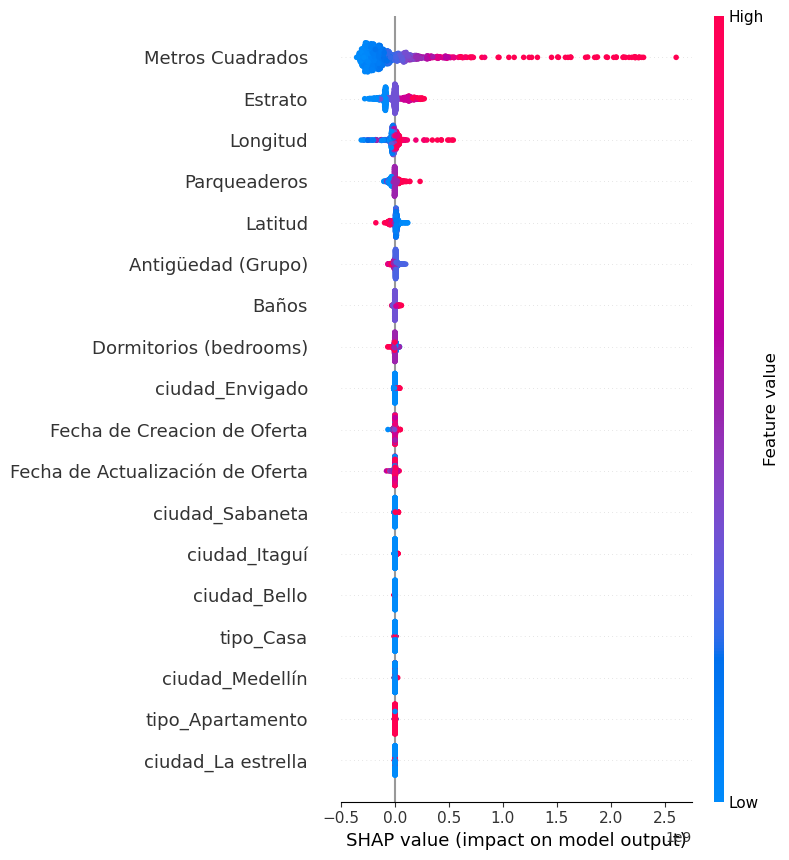

In [15]:
X = dm.drop(columns=["Precio"]) 
y = dm["Precio"]

#Separar train y test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 
model = RandomForestRegressor(n_estimators=200, random_state=seed)
model.fit(X_train, y_train)


explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)


shap.summary_plot(shap_values, X_test, plot_type="bar")

shap.summary_plot(shap_values, X_test)

### Análisis en los valores SHAP
Vemos que el análisis de SHAP con un modelo de RandomForest nos brinda información muy valiosa, dado que los valores más importantes en afectar el precio son los metros cuadrados de la casa, su estrato, su cantidad de parqueaderos, su ubicación y su antigüedad.

## División de datos (todas las variables)

In [16]:
X = dm.drop(columns=["Precio"])
y = dm["Precio"]

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=seed
)  # 0.25 * 0.8 = 0.2 total

print("Tamaños de los conjuntos:")
print(f"Entrenamiento: {len(X_train)} ({len(X_train)/len(dm)*100:.1f}%)")
print(f"Validación:    {len(X_val)} ({len(X_val)/len(dm)*100:.1f}%)")
print(f"Prueba:        {len(X_test)} ({len(X_test)/len(dm)*100:.1f}%)")

Tamaños de los conjuntos:
Entrenamiento: 2710 (60.0%)
Validación:    904 (20.0%)
Prueba:        904 (20.0%)


## Entrenamiento, Validación y Prueba

In [26]:
np.random.seed(42)

param_grid_dt = {
    "max_depth": np.random.randint(2, 20, 75),
    "min_samples_split": np.random.randint(2, 10, 75)
}

param_grid_rf = {
    "n_estimators": np.random.randint(50, 300, 75),
    "max_depth": np.random.randint(5, 25, 75),
    "min_samples_split": np.random.randint(2, 10, 75)
}

param_grid_gb = {
    "n_estimators": np.random.randint(50, 300, 75),
    "learning_rate": np.random.uniform(0.01, 0.2, 75),
    "max_depth": np.random.randint(2, 10, 75)
}

resultados = []

for i in range(75):
    dt = DecisionTreeRegressor(
        max_depth=param_grid_dt["max_depth"][i],
        min_samples_split=param_grid_dt["min_samples_split"][i],
        random_state=42
    )
    dt.fit(X_train, y_train)
    pred_dt = dt.predict(X_test)
    resultados.append({
        "modelo": "DecisionTree",
        "iter": i + 1,
        "max_depth": param_grid_dt["max_depth"][i],
        "min_samples_split": param_grid_dt["min_samples_split"][i],
        "MAE": mean_absolute_error(y_test, pred_dt),
        "MAPE": mean_absolute_percentage_error(y_test, pred_dt),
        "MSE": mean_squared_error(y_test, pred_dt)
    })
    rf = RandomForestRegressor(
        n_estimators=param_grid_rf["n_estimators"][i],
        max_depth=param_grid_rf["max_depth"][i],
        min_samples_split=param_grid_rf["min_samples_split"][i],
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    pred_rf = rf.predict(X_test)
    resultados.append({
        "modelo": "RandomForest",
        "iter": i + 1,
        "n_estimators": param_grid_rf["n_estimators"][i],
        "max_depth": param_grid_rf["max_depth"][i],
        "min_samples_split": param_grid_rf["min_samples_split"][i],
        "MAE": mean_absolute_error(y_test, pred_rf),
        "MAPE": mean_absolute_percentage_error(y_test, pred_rf),
        "MSE": mean_squared_error(y_test, pred_rf)
    })
    gb = GradientBoostingRegressor(
        n_estimators=param_grid_gb["n_estimators"][i],
        learning_rate=param_grid_gb["learning_rate"][i],
        max_depth=param_grid_gb["max_depth"][i],
        random_state=42
    )
    gb.fit(X_train, y_train)
    pred_gb = gb.predict(X_test)
    resultados.append({
        "modelo": "GradientBoosting",
        "iter": i + 1,
        "n_estimators": param_grid_gb["n_estimators"][i],
        "learning_rate": param_grid_gb["learning_rate"][i],
        "max_depth": param_grid_gb["max_depth"][i],
        "MAE": mean_absolute_error(y_test, pred_gb),
        "MAPE": mean_absolute_percentage_error(y_test, pred_gb),
        "MSE": mean_squared_error(y_test, pred_gb)
    })

resultados_df = pd.DataFrame(resultados).sort_values(by="MAE").reset_index(drop=True)

print("\n Mejores modelos encontrados (ordenados por MAE):")
print(resultados_df.head(1))
print(print("\n Mejores modelos encontrados (ordenados por MSE):"))
print(resultados_df.sort_values(by = "MSE").reset_index(drop=True).head(1))
print("\n Mejores modelos encontrados (ordenados por MAPE):")
print(resultados_df.sort_values(by = "MAPE").reset_index(drop=True).head(1))


 Mejores modelos encontrados (ordenados por MAE):
             modelo  iter  max_depth  min_samples_split           MAE  \
0  GradientBoosting    67          8                NaN  8.845874e+07   

       MAPE           MSE  n_estimators  learning_rate  
0  0.123323  3.715861e+16         141.0       0.139953  

 Mejores modelos encontrados (ordenados por MSE):
None
             modelo  iter  max_depth  min_samples_split           MAE  \
0  GradientBoosting    12          3                NaN  9.524203e+07   

       MAPE           MSE  n_estimators  learning_rate  
0  0.140616  3.105204e+16         177.0       0.193398  

 Mejores modelos encontrados (ordenados por MAPE):
             modelo  iter  max_depth  min_samples_split           MAE  \
0  GradientBoosting    67          8                NaN  8.845874e+07   

       MAPE           MSE  n_estimators  learning_rate  
0  0.123323  3.715861e+16         141.0       0.139953  


Encontramos que los tres mejores modelos para las tres métricas (MAE (Mean Absolute Error), MSE(Mean Squared Error) y MAPE (Mean Absoluto Percentage Error)) son versiones del GradientBoosting. Para hacer la ejecución de manera más rápida usamos la ejecución en paralelo, aprovechando todos los núcleos del procesador. 

### ¿Cual es la mejor métrica?
Consideramos que la métrica correcta es el MAE, esto es debido a que el MSE es muy penalizador ante errores muy grandes, y el MAE puede ser engañoso para rangos muy grandes de precios, como en este conjunto de datos. Por ende, se escoge el modelo Gradient Boosting con 8 de profundidad máxima, 141 estimadores. 

## Evaluación